In [2]:
import os, json, random, pathlib, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


DATA_DIR = "/kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2"  # <-- change if needed

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)


Found 23788 files belonging to 4 classes.


I0000 00:00:1755512939.395595      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755512939.396304      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [7]:
def compute_class_weights(dataset, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in dataset.unbatch():
        counts[y.numpy()] += 1
    total = counts.sum()
    weights = {i: float(total) / (n_classes * counts[i]) for i in range(n_classes)}
    return counts, weights

train_counts, class_weight = compute_class_weights(
    tf.keras.utils.image_dataset_from_directory(
        os.path.join(DATA_DIR, "train"),
        labels="inferred", label_mode="int", image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
    ),
    num_classes
)

print("Train counts per class:", dict(zip(class_names, train_counts)))
print("Class weights:", class_weight)

Found 23788 files belonging to 4 classes.
Train counts per class: {'MildDemented': 6272, 'ModerateDemented': 4524, 'NonDemented': 6720, 'VeryMildDemented': 6272}
Class weights: {0: 0.9481823979591837, 1: 1.3145446507515473, 2: 0.8849702380952381, 3: 0.9481823979591837}


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = num_classes  # taken from train_ds.class_names

# Build model (Sequential API)
model = Sequential(name="alzheimers_cnn_seq")
model.add(layers.Input(shape=INPUT_SHAPE))
model.add(layers.Rescaling(1.0 / 255.0))  # Normalization only

# ---- Block 1 (32 filters) ----
model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPooling2D())

# ---- Block 2 (64 filters) ----
model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPooling2D())

# ---- Head ----
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

# Compile model
initial_lr = 1e-3
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

# Example training call:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight,  # if computed
    #callbacks=callbacks,
)


Model: "alzheimers_cnn_seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,404 (290.64 KB)

 Trainable params: 74,404 (290.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1755513207.401027     104 service.cc:148] XLA service 0x7ad604010560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755513207.402287     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755513207.402308     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755513207.907339     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-18 10:33:37.203256: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

  2/744 ━━━━━━━━━━━━━━━━━━━━ 1:08 93ms/step - accuracy: 0.2188 - loss: 1.3573  

I0000 00:00:1755513219.766583     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


744/744 ━━━━━━━━━━━━━━━━━━━━ 96s 109ms/step - accuracy: 0.2747 - loss: 1.3813 - val_accuracy: 0.3488 - val_loss: 1.3128
Epoch 2/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.3630 - loss: 1.2852 - val_accuracy: 0.4301 - val_loss: 1.1834
Epoch 3/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.4605 - loss: 1.1312 - val_accuracy: 0.5217 - val_loss: 1.0369
Epoch 4/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.5218 - loss: 1.0180 - val_accuracy: 0.5509 - val_loss: 0.9588
Epoch 5/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.5741 - loss: 0.8826 - val_accuracy: 0.5625 - val_loss: 0.8864


In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,  # if computed
    #callbacks=callbacks,
)


Epoch 1/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.8462 - loss: 0.3406 - val_accuracy: 0.8136 - val_loss: 0.4514
Epoch 2/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8552 - loss: 0.3242 - val_accuracy: 0.8319 - val_loss: 0.3956
Epoch 3/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8524 - loss: 0.3261 - val_accuracy: 0.8638 - val_loss: 0.3469
Epoch 4/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8630 - loss: 0.3105 - val_accuracy: 0.8160 - val_loss: 0.4238
Epoch 5/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8659 - loss: 0.3035 - val_accuracy: 0.8270 - val_loss: 0.4245
Epoch 6/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8762 - loss: 0.2900 - val_accuracy: 0.8487 - val_loss: 0.3757
Epoch 7/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8748 - loss: 0.2853 - val_accuracy: 0.8782 - val_loss: 0.3104
Epoch 8/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8851 - loss: 0.2671 - 

PartitionExplainer explainer: 9it [00:22,  4.49s/it]                       


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Saved SHAP image overlays to ./shap_outputs


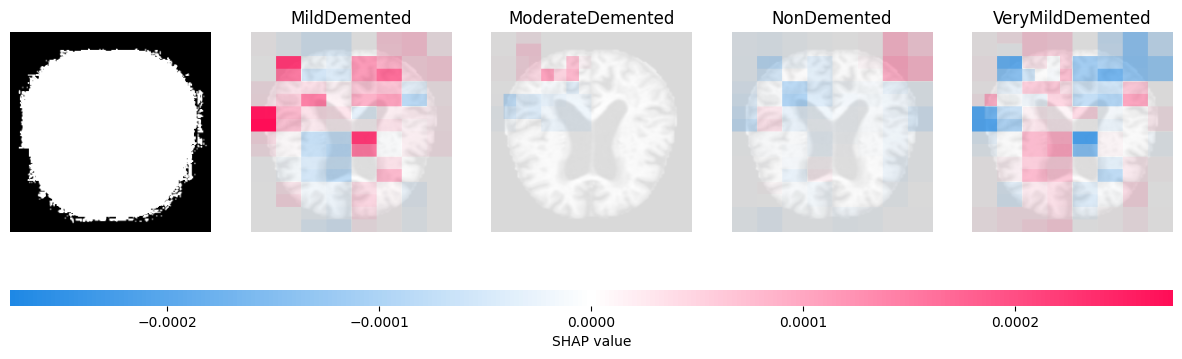

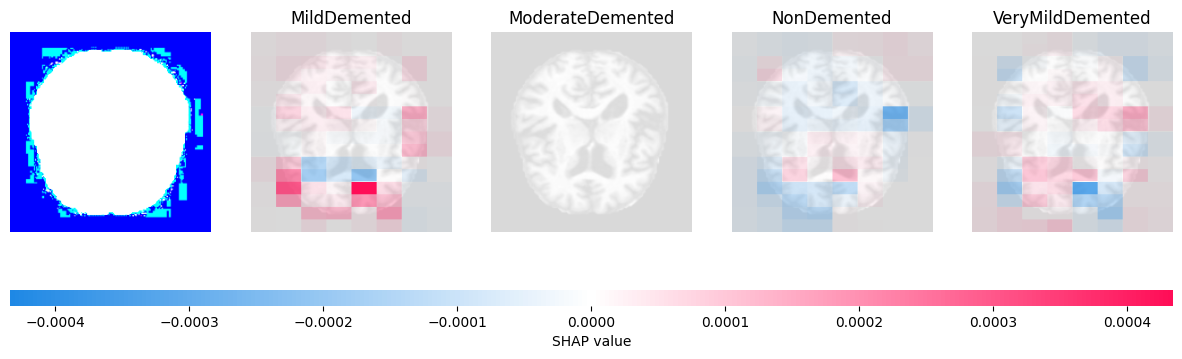

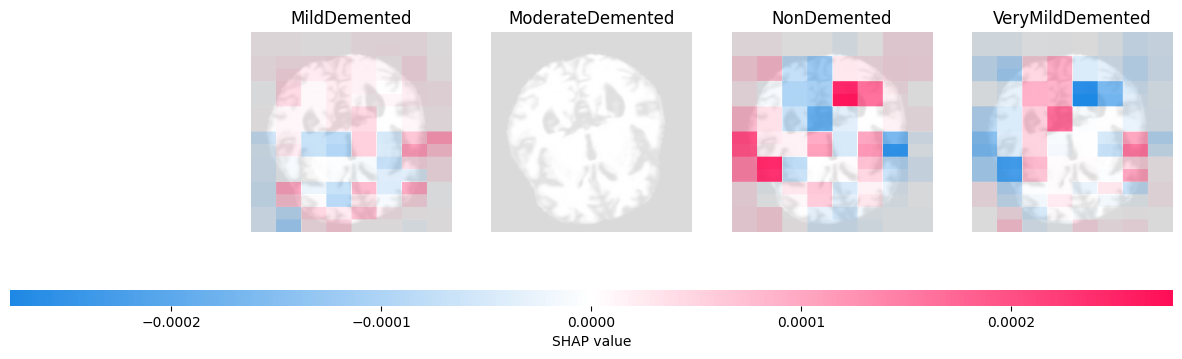

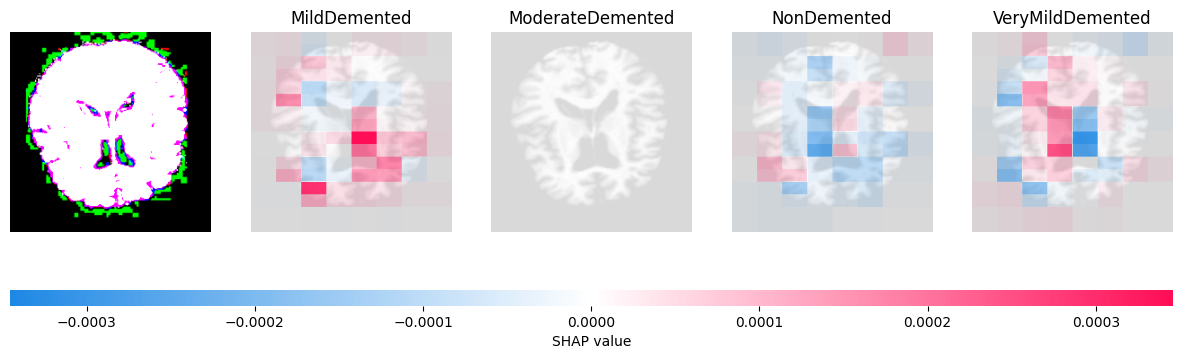

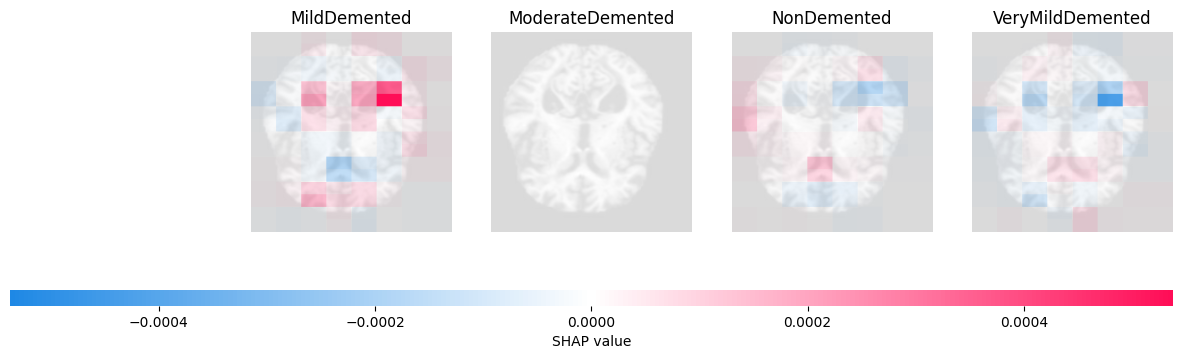

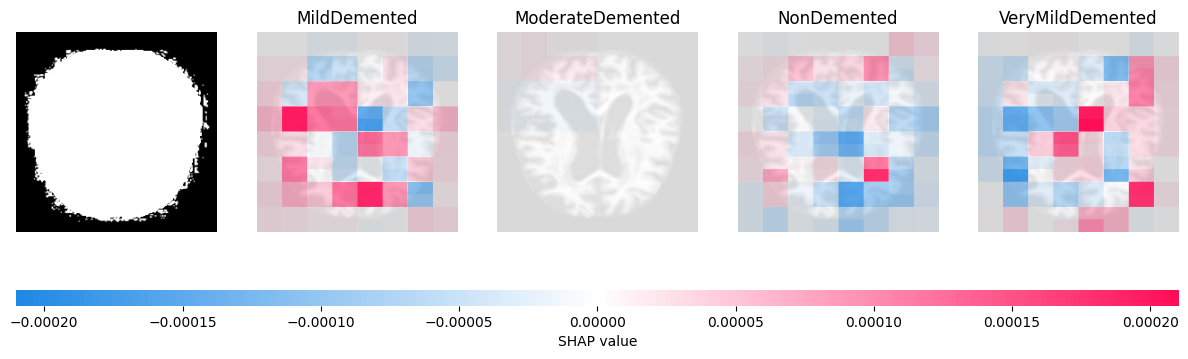

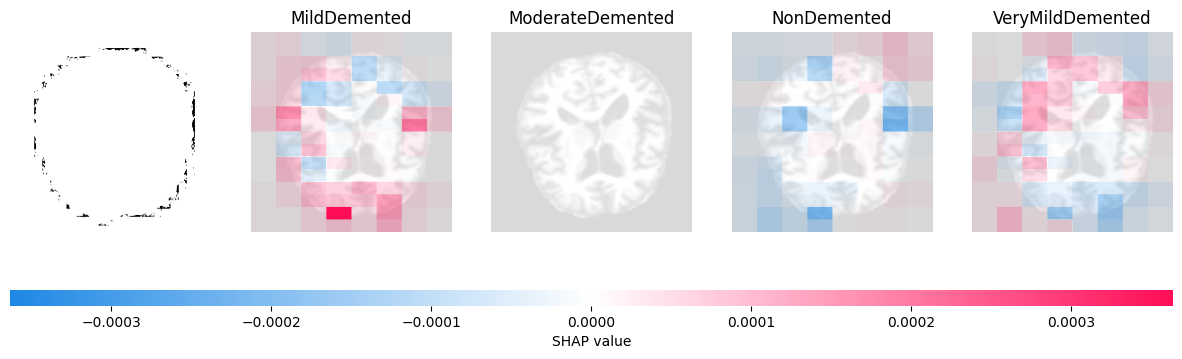

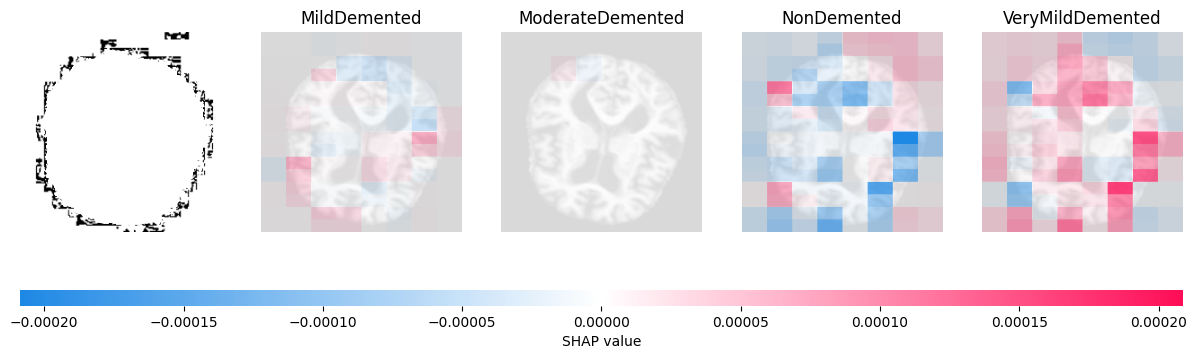

In [23]:
# ---------------------------
save_path = "alzheimers_cnn_seq.keras"
model.save(save_path)

loaded_model = tf.keras.models.load_model(save_path)

# ---------------------------
# 4) SHAP with TF2 eager: use shap.Explainer + Image masker (no graph mode)
#    NOTE: Image maskers expect images in [0,1]. Since our model includes a
#    Rescaling layer, we will still feed 0–1 images to SHAP for consistency.
# ---------------------------

def ds_to_numpy(ds, n):
    """Take n images from a tf.data.Dataset and stack to (n, H, W, C) float32."""
    xs = []
    for x, _ in ds.unbatch().take(n):
        xs.append(x.numpy())
    arr = np.stack(xs, axis=0).astype("float32")
    return arr

# Small background set (used by the masker and SHAP algorithm)
background = ds_to_numpy(train_ds, n=1000)  # [0,1]
# Samples to explain
samples = ds_to_numpy(test_ds, n=8)       # [0,1]

# Create an Image masker (blur is dependency-free; "inpaint_telea" needs OpenCV)
masker = shap.maskers.Image("blur(128,128)", samples[0].shape)

# Build explainer; SHAP will wrap the TF2 model under eager mode safely
explainer = shap.Explainer(loaded_model, masker, output_names=class_names)

# Compute explanations (you can tune max_evals/batch_size for speed/quality)
explanations = explainer(samples, max_evals=1000, batch_size=16)

# ---------------------------
# 5) Visualize & Save SHAP overlays
# ---------------------------
# On-screen (in notebooks):
# shap.image_plot(explanations)  # uncomment if your environment can display

# Save images to disk
os.makedirs("shap_outputs", exist_ok=True)
pred_probs = loaded_model.predict(samples)
pred_classes = np.argmax(pred_probs, axis=1)

for i in range(samples.shape[0]):
    fig = plt.figure()
    shap.image_plot(explanations[i:i+1], show=False)  # single-sample plot
    fig.savefig(f"shap_outputs/sample_{i}_pred_{class_names[pred_classes[i]]}.png",
                bbox_inches="tight")
    plt.close(fig)

print("Saved SHAP image overlays to ./shap_outputs")